In [9]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from keras import optimizers
import pandas as pd
from sklearn import preprocessing
import numpy as np
np.random.seed(4)
tf.random.set_seed(4)

In [10]:
history_days = 50

In [11]:
def csv_to_dataset(csv_file_path):
  file_data = pd.read_csv(csv_file_path)
  file_data = file_data.drop('date', axis=1)
  file_data = file_data.drop(0, axis=0)
  print("File data DataFrame:", file_data.shape)
  print(file_data.head())
  file_data = file_data.values
  
  normalizing_scaler = preprocessing.MinMaxScaler()
  normalized_data = normalizing_scaler.fit_transform(file_data)
  print()
  print("Normalized data")
  print(normalized_data[0:5,:])
  
  # Data is in order of: Open stock value, high value, low, close, and volume - ohlcv
  # Creates array of 5x50-value array windows, each one will be a training input into model
  ohlcv_histories_normalised = np.array([normalized_data[i : i + history_days].copy() for i in range(len(normalized_data) - history_days)])
  print()
  print("Normalized inputs", ohlcv_histories_normalised.shape)
  #print(ohlcv_histories_normalised[0:2,0:5])
  
  # Get scaled stock open price values, which model is predicting
  next_day_open_values_normalised = np.array([normalized_data[:,0][i + history_days].copy() for i in range(len(normalized_data) - history_days)])
  next_day_open_values_normalised = np.expand_dims(next_day_open_values_normalised, -1)
  #print()
  print("Next day open values scaled:", next_day_open_values_normalised.shape)
  
  # Get unscaled stock open price from original file data
  next_day_open_values = np.array([file_data[:,0][i + history_days].copy() for i in range(len(file_data) - history_days)])
  next_day_open_values = np.expand_dims(next_day_open_values, -1)
  print("Next day open values unscaled:", next_day_open_values.shape)

  y_normaliser = preprocessing.MinMaxScaler()
  y_normaliser.fit(next_day_open_values)

  # Moving average technical indicator of stock price input
  moving_averages = []
  for his in ohlcv_histories_normalised:
    sma = np.mean(his[:,3]) # Using closing price of the stocks for the moving average, not open price
    moving_averages.append(np.array([sma]))

  moving_averages = np.array(moving_averages) # Convert to numpy array
  moving_averages_scaler = preprocessing.MinMaxScaler() # Scale with min-max scaler
  moving_averages_normalised = moving_averages_scaler.fit_transform(moving_averages)

  assert ohlcv_histories_normalised.shape[0] == next_day_open_values_normalised.shape[0] == moving_averages_normalised.shape[0]
  return ohlcv_histories_normalised, moving_averages_normalised, next_day_open_values_normalised, next_day_open_values, y_normaliser

In [12]:
# Load preprocessed dataset of stock prices
ohlcv_histories, moving_averages, next_day_open_values, unscaled_open_prices, y_normaliser = csv_to_dataset('MSFT_daily.csv')

# Split into test and training sets
train_split = 0.8
n = int(ohlcv_histories.shape[0] * train_split)

ohlcv_train = ohlcv_histories[:n]
mov_avg_train = moving_averages[:n]
open_prices_train = next_day_open_values[:n]

ohlcv_test = ohlcv_histories[n:]
mov_avg_test = moving_averages[n:]
open_prices_test = next_day_open_values[n:]

unscaled_open_prices_test = unscaled_open_prices[n:]

File data DataFrame: (5254, 5)
   1. open  2. high  3. low  4. close   5. volume
1   200.05   204.33  199.96    202.91  34011257.0
2   210.62   210.65  204.64    205.05  26372464.0
3   208.42   209.78  206.93    208.78  21823942.0
4   204.24   209.20  204.03    205.41  30375768.0
5   207.20   208.63  201.24    204.03  33620073.0

Normalized data
[[0.86350259 0.86867059 0.87109375 0.86725173 0.04812097]
 [0.91287896 0.89776284 0.89311935 0.87713626 0.03506769]
 [0.90260195 0.89375806 0.90389684 0.8943649  0.02729512]
 [0.88307563 0.8910882  0.89024849 0.87879908 0.04190859]
 [0.89690288 0.88846437 0.87711785 0.87242494 0.04745251]]

Normalized inputs (5204, 50, 5)
Next day open values scaled: (5204, 1)
Next day open values unscaled: (5204, 1)


In [14]:
# Build Model v2 - more complex layers, 2 inputs
# Two sets of input into model - previous stock prices over time and the techincal indicator (moving average)
lstm_input = Input(shape=(history_days, 5), name='lstm_input')
dense_input = Input(shape=(moving_averages.shape[1],), name='tech_input')
 
# First branch of model has layers for first input, stock prices from data
x = LSTM(50, name='lstm_0')(lstm_input)
x = Dropout(0.2, name='lstm_dropout_0')(x)
lstm_branch = Model(inputs=lstm_input, outputs=x)
 
# Second branch - Moving Average technical indicator input
y = Dense(20, name='tech_dense_0')(dense_input)
y = Activation("relu", name='tech_relu_0')(y)
y = Dropout(0.2, name='tech_dropout_0')(y)
moving_averages_branch = Model(inputs=dense_input, outputs=y)
 
# Combine two branches
combined_branches = concatenate([lstm_branch.output, moving_averages_branch.output], name='concatenate')
z = Dense(64, activation="sigmoid", name='dense_pooling')(combined_branches)
z = Dense(1, activation="linear", name='dense_out')(z)
 
# Model takes inputs from both branches, outputs a single value
model = Model(inputs=[lstm_branch.input, moving_averages_branch.input], outputs=z)
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse')

In [15]:
model.fit(x=[ohlcv_train, mov_avg_train], y=open_prices_train, batch_size=32, epochs=50, shuffle=True, validation_split=0.1)

Epoch 1/50
132/132 [==============================] - 6s 48ms/step - loss: 0.0082 - val_loss: 4.1229e-04
Epoch 2/50
132/132 [==============================] - 5s 39ms/step - loss: 4.8606e-04 - val_loss: 2.4446e-04
Epoch 3/50
132/132 [==============================] - 6s 48ms/step - loss: 4.1767e-04 - val_loss: 4.2876e-04
Epoch 4/50
132/132 [==============================] - 6s 48ms/step - loss: 3.6219e-04 - val_loss: 2.1700e-04
Epoch 5/50
132/132 [==============================] - 6s 49ms/step - loss: 3.0678e-04 - val_loss: 2.4941e-04
Epoch 6/50
132/132 [==============================] - 6s 49ms/step - loss: 3.1355e-04 - val_loss: 1.9666e-04
Epoch 7/50
132/132 [==============================] - 6s 48ms/step - loss: 3.0258e-04 - val_loss: 2.2659e-04
Epoch 8/50
132/132 [==============================] - 6s 48ms/step - loss: 2.7085e-04 - val_loss: 2.3657e-04
Epoch 9/50
132/132 [==============================] - 6s 48ms/step - loss: 2.6657e-04 - val_loss: 2.2587e-04
Epoch 10/50
132/132 [==

In [18]:
evaluation = model.evaluate([ohlcv_test, mov_avg_test], open_prices_test)
print(evaluation)

17/17 [==============================] - 0s 12ms/step - loss: 2.8134e-04
0.00028133546584285796


In [19]:
# Evaluate model
# Open prices prediction
open_prices_test_predicted = model.predict([ohlcv_test, mov_avg_test])
open_prices_test_predicted = y_normaliser.inverse_transform(open_prices_test_predicted)

# Entire dataset prediction
open_prices_predicted = model.predict([ohlcv_histories, moving_averages])
open_prices_predicted = y_normaliser.inverse_transform(open_prices_predicted)

assert unscaled_open_prices_test.shape == open_prices_test_predicted.shape
real_mse = np.mean(np.square(unscaled_open_prices_test - open_prices_test_predicted))
scaled_mse = real_mse / (np.max(unscaled_open_prices_test) - np.min(unscaled_open_prices_test)) * 100
print(scaled_mse)

67.47218118226142


In [21]:
import matplotlib.pyplot as plt

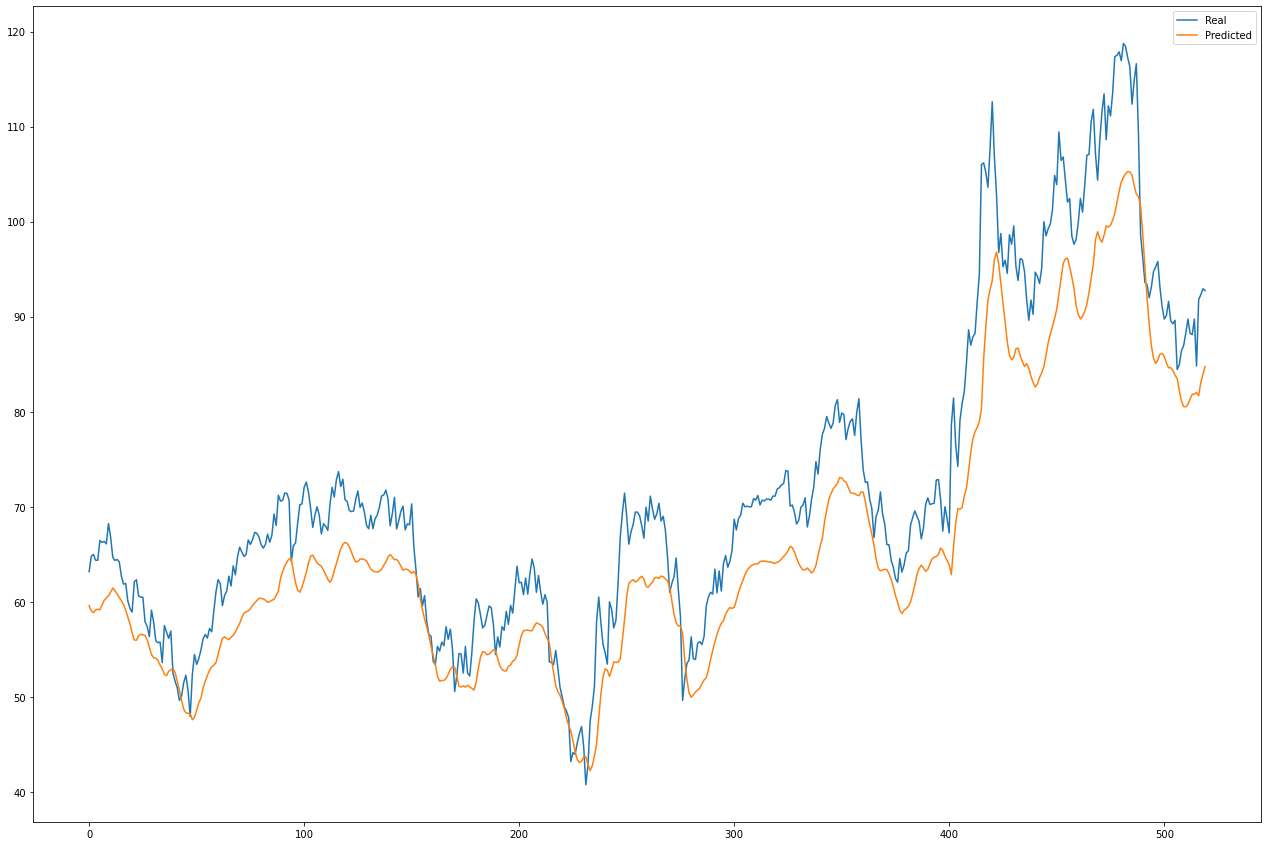

In [22]:
# Plot Predictions and real values
plt.gcf().set_size_inches(22, 15, forward=True)
start = 0
end = -1
real = plt.plot(unscaled_open_prices_test[start:end], label='real')
pred = plt.plot(open_prices_test_predicted[start:end], label='predicted')

plt.legend(['Real', 'Predicted'])

plt.show()